In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers,Input,Model,activations,Sequential,callbacks
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
(x_train, y_train_), (x_val, y_val_) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_val = np.expand_dims(x_val, -1).astype("float32") / 255

In [7]:
def auto_encoder(input_shape=(28, 28,1),code_size=9):
    input_img = Input(shape=input_shape, name="encoder_input")
    x      = layers.Conv2D(filters=1,kernel_size=3, padding='same', activation="relu",kernel_initializer='he_normal')(input_img)
    x      = layers.Flatten()(x)
    x      = layers.Dense(150, activation="elu",kernel_initializer='he_normal')(x)
    x      = layers.Dense(30, activation="elu",kernel_initializer='he_normal')(x)
    code   = layers.Dense(code_size, activation="elu",kernel_initializer='he_normal')(x)

    De_in=Input(shape=(code_size,) , name="decoder_input")
    z      = layers.Dense(30, activation="elu",kernel_initializer='he_normal')(De_in)
    z      = layers.Dense(150, activation="elu",kernel_initializer='he_normal')(z)
    z      = layers.Dense(input_shape[0]*input_shape[1], activation="elu",kernel_initializer='he_normal')(z)
    z      = layers.Reshape((28, 28, 1))(z)

    de_out = layers.Conv2DTranspose(filters=1,kernel_size=1,activation='relu',padding='same',kernel_initializer='he_normal')(z)

    Encoder=Model(input_img, code)
    Decoder=Model(De_in, de_out)

    code_decoded=Decoder(code)

    Autoencoder=Model(input_img, code_decoded)



    learning_rate=0.003
    optimizer   = keras.optimizers.Adam(learning_rate=learning_rate)
    Autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return Encoder,Decoder,Autoencoder

In [8]:
Encoder,Decoder,Autoencoder= auto_encoder(input_shape=(28, 28,1),code_size=9)
Autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         10        
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 150)               117750    
                                                                 
 dense_7 (Dense)             (None, 30)                4530      
                                                                 
 dense_8 (Dense)             (None, 9)                 279       
                                                                 
 model_4 (Functional)        (None, 28, 28, 1)         1233

In [9]:
reduce_LR = callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error',patience=2, verbose=1, factor=0.5, min_lr=0.000000001)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True,verbose=0)


In [10]:
weights_file = 'Tsne_mnist_mlp.h5'

if os.path.exists(weights_file):
    Autoencoder.load_weights(weights_file)
    my_history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print('Loaded weights!')
else:
    history_keras =  Autoencoder.fit(x_train,x_train, epochs=200, validation_data=(x_val,x_val), callbacks=[early_stopping],verbose=1)
    Autoencoder.save_weights('Tsne_mnist_mlp.h5')
    np.save('my_history.npy',history_keras.history)
    my_history=history_keras.history

Loaded weights!


In [ ]:
Autoencoder.predict

In [11]:
x_test_predicted=Autoencoder.predict(x_val)


In [12]:
x_val.shape

(10000, 28, 28, 1)

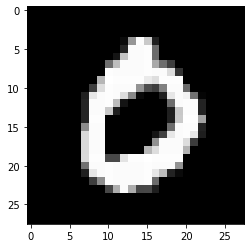

In [13]:
plt.imshow(x_val[3], cmap='gray',)

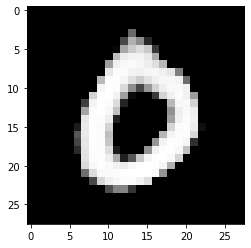

In [14]:
plt.imshow(x_test_predicted[3], cmap='gray',)